In [76]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate

In [2]:
from toy_tools import *

In [80]:
def smooth_wf(wf, thres, roi, delay, npoints=10_000, **kwargs):
    extrapolate= kwargs.get('extrapolate', False)
    wf_new = np.zeros(npoints)
    dts = np.append(wf[0][0], np.diff(wf[0]))
    seri = []
    for i in range(len(wf[0])):
        if i == 0:
            if wf[0][0] > roi:
                t0 = wf[0][0]-roi
            else:
                t0 = 0
            t1 = wf[0][0]
        else:
            dt = wf[0][i] - wf[0][i-1]
            print(dt)
            t0 = wf[0][i] - dt + delay
            t1 = wf[0][i]
        t0 = np.int_(t0+0.002)
        t1 = np.int_(t1+0.002)
        t2 = np.int_(t1+delay+0.002)
        seri.append([t0, t1, thres])
        seri.append([t1, t2, wf[1][i]-thres])
    seri_array = np.array(seri)
    # print(wf[0])
    print(seri)

    acc_wf = np.add.accumulate(seri_array[:,2])
    acc_wf = np.append([0], acc_wf)
    acc_wf = np.append(acc_wf, [acc_wf[-1]])
    ticks = seri_array[:,0]
    ticks = np.append(ticks, seri_array[-1,1])
    ticks = np.append(ticks, seri_array[-1,1]+roi)
    
    for i in range(len(seri)):
        #
        t0, t1, v1 = seri[i]
        b1 = v1/(t1-t0)
        if not extrapolate:
            wf_new[t0:t1] = b1
    if extrapolate:
        print(ticks)
        # raise NotImplementedError("try not extrapolate")
        xs = np.arange(ticks[0], ticks[-1]+1, 1) if ticks[-1] < npoints else np.arange(ticks[0], npoints+1, 1)
        acc_wf_ext = pchip_interpolate(ticks, acc_wf, xs)
        wf_new[np.int_(ticks[0]) : np.int_(ticks[-1])] = np.diff(acc_wf_ext)
    return wf_new

In [86]:
def smooth_wf2(wf, thres, roi, delay, npoints=10_000, **kwargs):
    wf_new = np.zeros(npoints)
    dts = np.append(wf[0][0], np.diff(wf[0]))
    seri = []
    for i in range(len(wf[0])):
        if i == 0:
            if wf[0][0] > roi:
                t0 = wf[0][0]-roi
            else:
                t0 = 0
            t1 = wf[0][0]
        else:
            dt = wf[0][i] - wf[0][i-1]
            print(dt)
            t0 = wf[0][i] - dt + delay
            t1 = wf[0][i]
        t0 = np.int_(t0+0.002)
        t1 = np.int_(t1+0.002)
        t2 = np.int_(t1+delay+0.002)
        if t2 - t0 < roi+delay:
            seri.append([t0, t2, wf[1][i]])
        else:
            seri.append([t0, t1, thres])
            seri.append([t1, t2, wf[1][i]-thres])
    seri_array = np.array(seri)
    # print(wf[0])
    print(seri)

    acc_wf = np.add.accumulate(seri_array[:,2])
    acc_wf = np.append([0], acc_wf)
    acc_wf = np.append(acc_wf, [acc_wf[-1]])
    ticks = seri_array[:,0]
    ticks = np.append(ticks, seri_array[-1,1])
    ticks = np.append(ticks, seri_array[-1,1]+roi)
    
    for i in range(len(seri)):
        #
        t0, t1, v1 = seri[i]
        b1 = v1/(t1-t0)
        wf_new[t0:t1] = b1
    return wf_new

In [89]:
def smooth_wf3(wf, thres, roi, delay, npoints=10_000, **kwargs):
    wf_new = np.zeros(npoints)
    dts = np.append(wf[0][0], np.diff(wf[0]))
    seri = []
    for i in range(len(wf[0])):
        if i == 0:
            t0 = wf[0][0]
            t1 = wf[0][0]
        else:
            dt = wf[0][i] - wf[0][i-1]
            print(dt)
            t0 = wf[0][i] - dt + delay
            t1 = wf[0][i]
        t0 = np.int_(t0+0.002)
        t1 = np.int_(t1+0.002)
        t2 = np.int_(t1+delay+0.002)

        seri.append([t0, t2, wf[1][i]])

    seri_array = np.array(seri)
    # print(wf[0])
    print(seri)

    acc_wf = np.add.accumulate(seri_array[:,2])
    acc_wf = np.append([0], acc_wf)
    acc_wf = np.append(acc_wf, [acc_wf[-1]])
    ticks = seri_array[:,0]
    ticks = np.append(ticks, seri_array[-1,1])
    ticks = np.append(ticks, seri_array[-1,1]+roi)
    
    for i in range(len(seri)):
        #
        t0, t1, v1 = seri[i]
        b1 = v1/(t1-t0)
        wf_new[t0:t1] = b1
    return wf_new

In [82]:
def run(extrapolate=False, fsmooth=smooth_wf):
    pos = 8700
    q = 30_600
    delay = 15
    thres = 6_000
    roi = 5*delay
    npoints = 10_000
    
    unit_fr = load_fr_ctr('response_44_v2a_100ns.npy')
    q0 = q*np.ones(1)
    # from toy_translation.ipynb
    r = 20
    sigma = 2
    q1 = q_gaus(q=q, r=21, sigma=sigma)
    fr0 = fr_record(q0, pos, unit_fr)
    fr1 = fr_record(q1, pos, unit_fr)

    r0 = readout(fr0, thres=thres, delay=delay)
    r1 = readout(fr1, thres=thres, delay=delay)

    r0_smooth = fsmooth(wf=r0, thres=thres, roi=roi, delay=delay, npoints=npoints, extrapolate=extrapolate)
    r1_smooth = fsmooth(wf=r1, thres=thres, roi=roi, delay=delay, npoints=npoints, extrapolate=extrapolate)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5*2, 3))
    ax0.bar(r0[0], np.add.accumulate(r0[1]), width=delay, color='r', align='edge', label='readout')
    ax0.plot(np.add.accumulate(r0_smooth))
    ax1.bar(r0[0], r0[1], width=delay, color='r', align='edge', label='readout')
    ax1.plot(r0_smooth)
    ax0.set_xlim(800, 1300)
    ax1.set_xlim(1100, 1300)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5*2, 3))
    ax0.bar(r1[0], np.add.accumulate(r1[1]), width=delay, color='r', align='edge', label='readout')
    ax0.plot(np.add.accumulate(r1_smooth))
    ax1.bar(r1[0], r1[1], width=delay, color='r', align='edge', label='readout')
    ax1.plot(r1_smooth)
    ax0.set_xlim(800, 1300)
    ax1.set_xlim(1100, 1300)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
17.0
[[1104, 1179, 6000], [1179, 1194, 12770.612597685362], [1194, 1196, 6000], [1196, 1211, 3566.283843871779]]
18.0
[[1114, 1189, 6000], [1189, 1204, 13428.274903172776], [1204, 1207, 6000], [1207, 1222, 2952.5563540967305]]


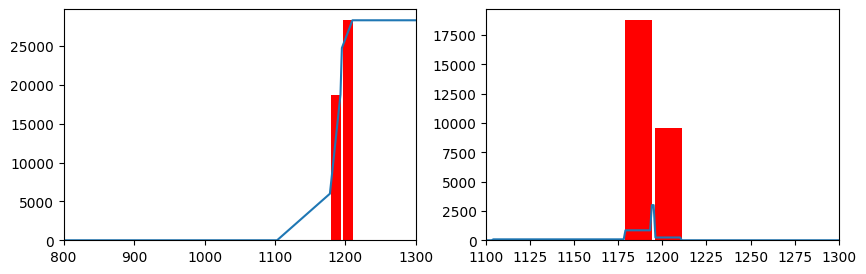

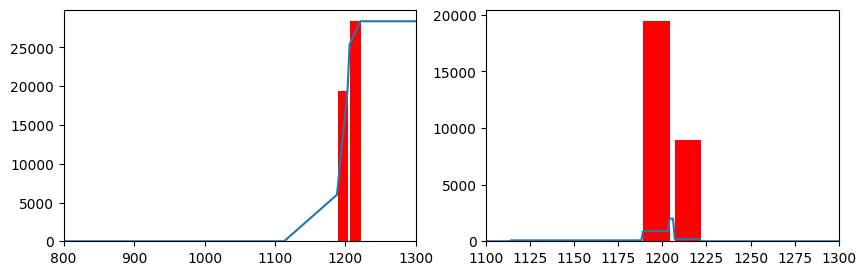

In [83]:
run()

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
17.0
[[1104, 1179, 6000], [1179, 1194, 12770.612597685362], [1194, 1196, 6000], [1196, 1211, 3566.283843871779]]
[1104. 1179. 1194. 1196. 1211. 1286.]
18.0
[[1114, 1189, 6000], [1189, 1204, 13428.274903172776], [1204, 1207, 6000], [1207, 1222, 2952.5563540967305]]
[1114. 1189. 1204. 1207. 1222. 1297.]


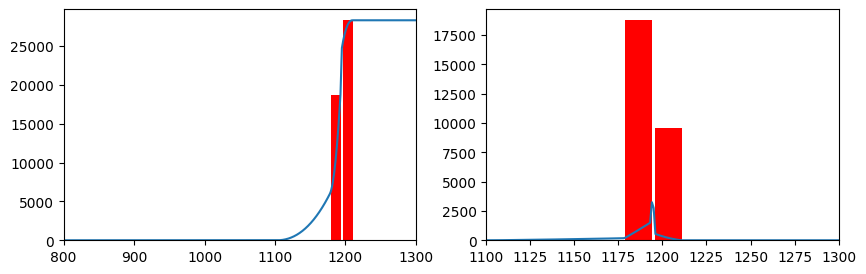

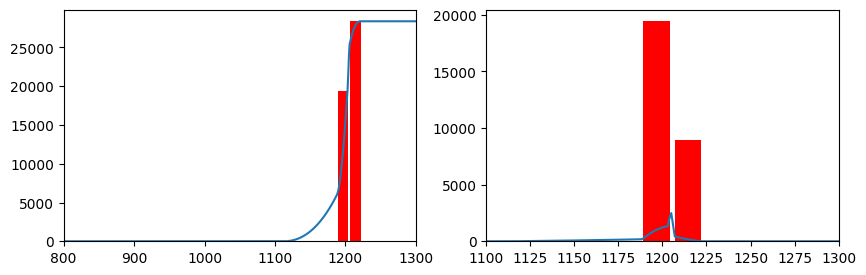

In [84]:
run(True)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
17.0
[[1104, 1179, 6000], [1179, 1194, 12770.612597685362], [1194, 1211, 9566.283843871779]]
18.0
[[1114, 1189, 6000], [1189, 1204, 13428.274903172776], [1204, 1222, 8952.55635409673]]


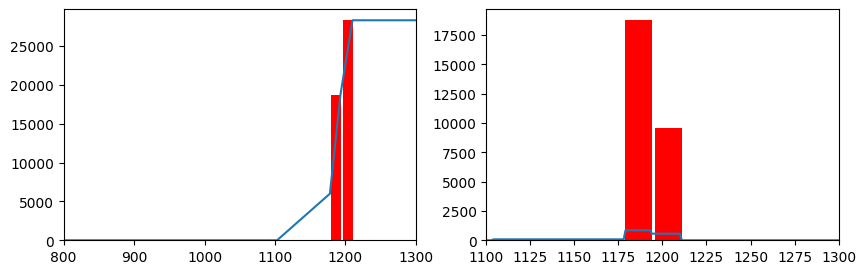

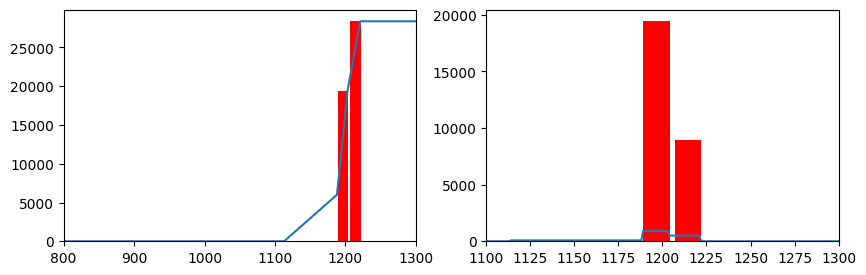

In [87]:
run(False, smooth_wf2)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
17.0
[[1179, 1194, 18770.612597685362], [1194, 1211, 9566.283843871779]]
18.0
[[1189, 1204, 19428.274903172776], [1204, 1222, 8952.55635409673]]


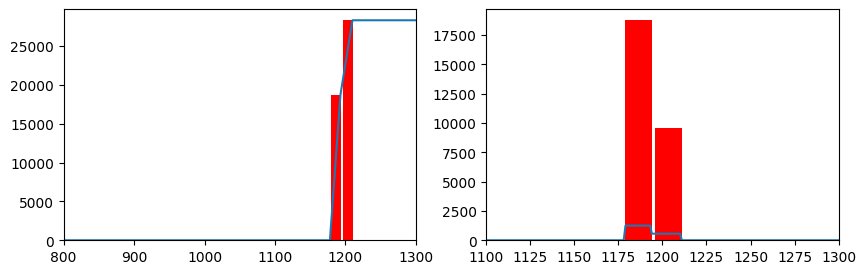

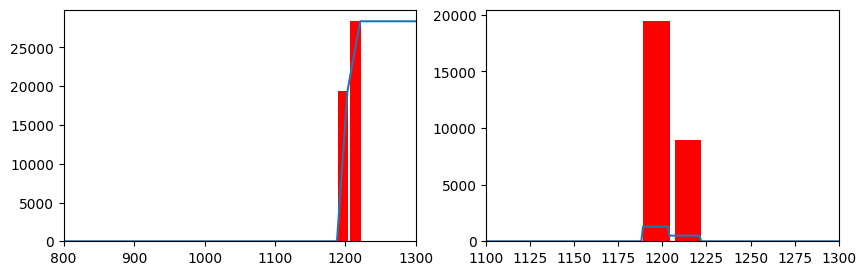

In [90]:
run(False, smooth_wf3)